# <font color = lightcoral>Startover with basic ML Model
>    
>Startover

## <font color = grey> Admin

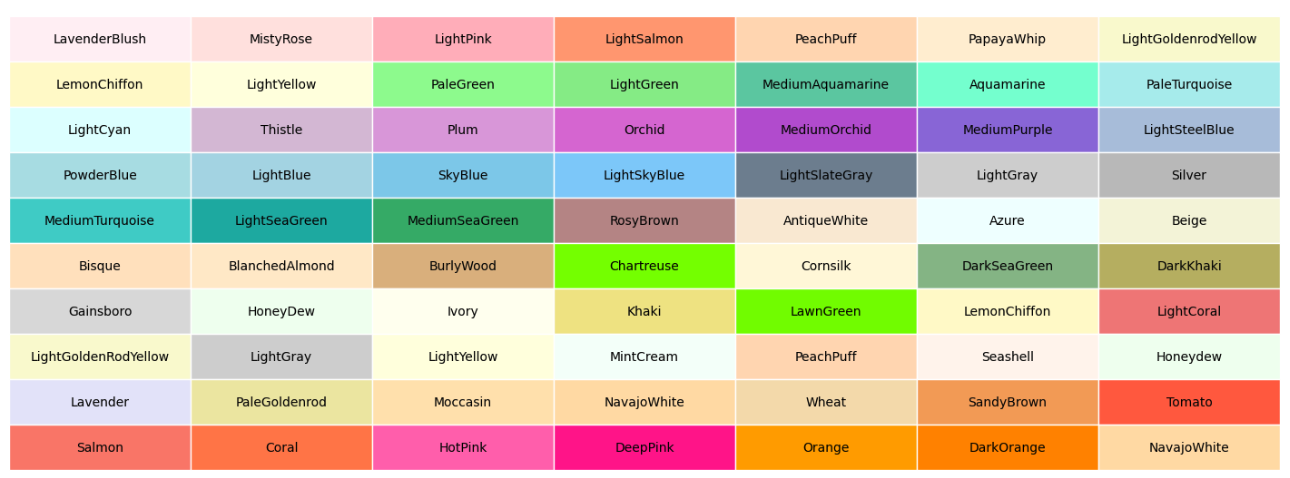

In [1]:
import pandas as pd
import os
import gzip
import time
import warnings
import os
import shutil
from datetime import datetime
# Set display option to show the full length of the column
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
# Determine the base directory based on the effective user ID
if os.geteuid() == 0:  # root user
    base_dir = '/root'
else:
    base_dir = '/home/sagemaker-user'

# Set the environment variable
os.environ['BASE_DIR'] = base_dir

# Verify the base directory
print(f"Base directory set to: {base_dir}")

Base directory set to: /home/sagemaker-user


___
# <font color = darkkhaki> (D). Feature Engg - Advanced (TBD)

___
# <font color = tomato> PreProcess Data

#### Revise current function to preprocess the 3 files

In [5]:
# import pandas as pd
# import os

# # Function to preprocess the data
# def preprocess_data(df):
#     # Convert hexadecimal strings to integers
#     def hex_to_int(hex_list):
#         if hex_list is None or len(hex_list) == 0:
#             return 0  # Return 0 for None or empty lists
#         try:
#             return int(hex_list[0][1:-1], 16)
#         except (ValueError, IndexError, TypeError):
#             return 0  # Return 0 for any conversion errors

#     df = df.applymap(hex_to_int)
    
#     return df

# # Define the target folder
# target_folder = '/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl'

# # Define file paths
# file_paths = {
#     'train': os.path.join(target_folder, 'train.parquet'),
#     'test_normal': os.path.join(target_folder, 'test_normal.parquet'),
#     'test_abnormal': os.path.join(target_folder, 'test_abnormal.parquet')
# }

# # Process each file
# for file_key, file_path in file_paths.items():
#     # Read the Parquet file
#     df = pd.read_parquet(file_path)
    
#     # Preprocess data
#     df = preprocess_data(df)
    
#     # Save the preprocessed DataFrame as a Parquet file
#     preprocessed_file_path = os.path.join(target_folder, f'{file_key}_preprocessed.parquet')
#     df.to_parquet(preprocessed_file_path)
    
#     print(f'Preprocessed {file_key} data saved to {preprocessed_file_path}')

# # Function to display file info
# def display_file_info(file_key, file_path):
#     df = pd.read_parquet(file_path)
#     print(f'--- {file_key} ---')
#     print(f'Number of rows: {df.shape[0]}')
#     print(f'Number of columns: {df.shape[1]}')
#     # print(df.head())
#     print('\n')

# # Display info for each file
# for file_key, file_path in file_paths.items():
#     preprocessed_file_path = os.path.join(target_folder, f'{file_key}_preprocessed.parquet')
#     display_file_info(file_key, preprocessed_file_path)

#### Load and Review

In [4]:
import pandas as pd
import os

# Define the target folder
target_folder = '/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl'

# Define file paths for the preprocessed files
file_paths = {
    # 'train': os.path.join(target_folder, 'train_preprocessed.parquet')
    # ,
    'test_normal': os.path.join(target_folder, 'test_normal_preprocessed.parquet')
    ,
    # 'test_abnormal': os.path.join(target_folder, 'test_abnormal_preprocessed.parquet')
}

# Function to display file info
def display_file_info(file_key, file_path):
    df = pd.read_parquet(file_path)
    print(f'--- {file_key} ---')
    print(f'Number of rows: {df.shape[0]}')
    print(f'Number of columns: {df.shape[1]}')
    print(df.head())
    print('\n')

# Display info for each file
for file_key, file_path in file_paths.items():
    display_file_info(file_key, file_path)

--- test_normal ---
Number of rows: 20579
Number of columns: 42794
      0         1        2         3        4         5        6        7      \
0   8654015   8654015  8654015   6235107  6235107   6235107  6235107  6235107   
1    411112  10743712   411112  10743712   411112  10743712   411112   411112   
2  10975928         0        0         0        0         0        0        0   
3  11161828         0        0         0        0         0        0        0   
4  12504070         0        0         0        0         0        0        0   

     8         9         10        11       12       13       14        15     \
0  6235107   6235107   4706255   6235107  6235107  4706255  6235107   6235107   
1   411112  10743712  10743712  10743712   411112   411112   411112  10743712   
2        0         0         0         0        0        0        0         0   
3        0         0         0         0        0        0        0         0   
4        0         0         0         0 

___
# <font color = darkkhaki> Decision Tree - Basic (ChatGPT)

In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_path = '/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/train_preprocessed.parquet'
test_normal_path = '/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/test_normal_preprocessed.parquet'
test_abnormal_path = '/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/test_abnormal_preprocessed.parquet'

train_df = pd.read_parquet(train_path)
test_normal_df = pd.read_parquet(test_normal_path)
test_abnormal_df = pd.read_parquet(test_abnormal_path)

# Adjusting the number of columns to be the same across all datasets
max_columns = max(train_df.shape[1], test_normal_df.shape[1], test_abnormal_df.shape[1])
train_df = train_df.reindex(columns=range(max_columns), fill_value=0)
test_normal_df = test_normal_df.reindex(columns=range(max_columns), fill_value=0)
test_abnormal_df = test_abnormal_df.reindex(columns=range(max_columns), fill_value=0)

In [8]:
# Use a portion of test_abnormal_df as class 1 training data
abnormal_train_portion = test_abnormal_df.sample(frac=0.3, random_state=42)  # Adjust the fraction as needed
remaining_abnormal_test = test_abnormal_df.drop(abnormal_train_portion.index)

# Combine real and synthetic data
X_train_combined = pd.concat([train_df, abnormal_train_portion])
y_train_combined = [0] * train_df.shape[0] + [1] * abnormal_train_portion.shape[0]

In [9]:
# Define labels for test sets
y_test_normal = [0] * test_normal_df.shape[0]
y_test_abnormal = [1] * remaining_abnormal_test.shape[0]

# Scale the features
scaler = StandardScaler()
X_train_combined_scaled = scaler.fit_transform(X_train_combined)
X_test_normal_scaled = scaler.transform(test_normal_df)
X_test_abnormal_scaled = scaler.transform(remaining_abnormal_test)

In [10]:
# Reduce dimensionality with PCA
pca = PCA(n_components=100)  # Adjust n_components based on the explained variance
X_train_pca = pca.fit_transform(X_train_combined_scaled)
X_test_normal_pca = pca.transform(X_test_normal_scaled)
X_test_abnormal_pca = pca.transform(X_test_abnormal_scaled)

In [11]:
# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_pca, y_train_combined)

LogisticRegression(max_iter=1000)

---

In [12]:
# Predict on test_normal data
y_pred_normal = model.predict(X_test_normal_pca)
accuracy_normal = accuracy_score(y_test_normal, y_pred_normal)

In [13]:
# Predict on test_abnormal data
y_pred_abnormal = model.predict(X_test_abnormal_pca)
accuracy_abnormal = accuracy_score(y_test_abnormal, y_pred_abnormal)

In [14]:
print(f"Accuracy on normal test data: {accuracy_normal}")
print(f"Accuracy on abnormal test data: {accuracy_abnormal}")

Accuracy on normal test data: 0.9966956606249089
Accuracy on abnormal test data: 0.12920018930430668


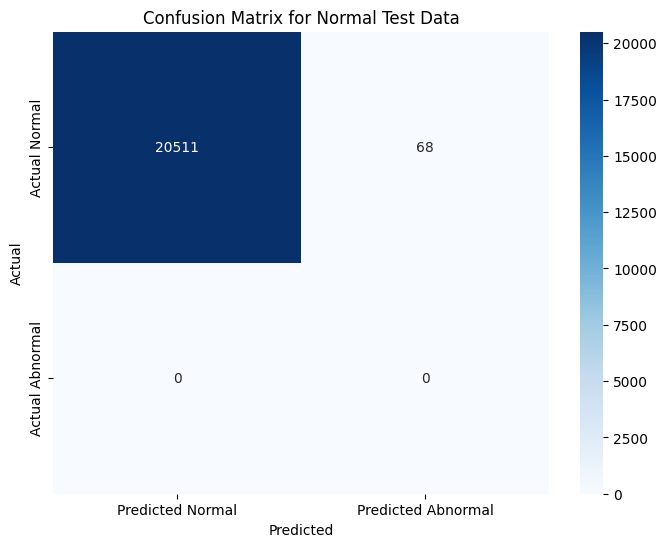

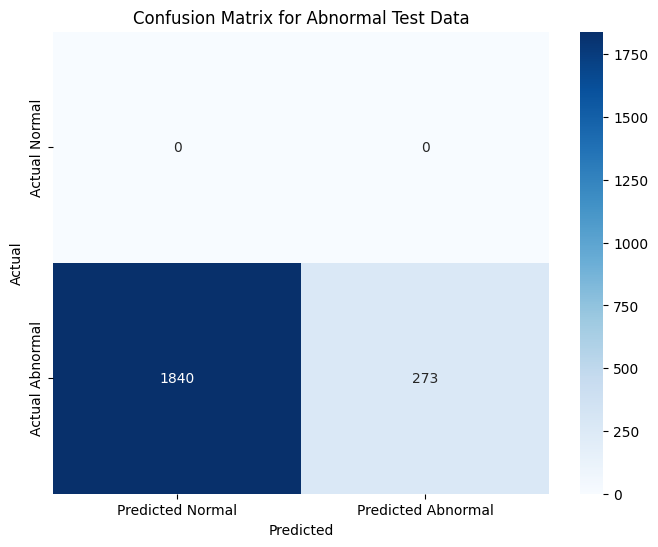

In [15]:
# Confusion matrix for test_normal
conf_matrix_normal = confusion_matrix(y_test_normal, y_pred_normal)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normal, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Abnormal'], yticklabels=['Actual Normal', 'Actual Abnormal'])
plt.title('Confusion Matrix for Normal Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion matrix for test_abnormal
conf_matrix_abnormal = confusion_matrix(y_test_abnormal, y_pred_abnormal)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_abnormal, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Abnormal'], yticklabels=['Actual Normal', 'Actual Abnormal'])
plt.title('Confusion Matrix for Abnormal Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

___
# <font color = darkkhaki> IsolationForest - Basic (Claude)

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix, hstack
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

# 1. Load the data
train_data = pd.read_parquet('/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/train_preprocessed.parquet')
test_normal = pd.read_parquet('/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/test_normal_preprocessed.parquet')
test_abnormal = pd.read_parquet('/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/test_abnormal_preprocessed.parquet')

# 2. Feature engineering (same as before)
def get_event_counts(df):
    return (df != 0).sum(axis=1).values.reshape(-1, 1)

def get_unique_events(df):
    return np.unique(df.values)

train_events = get_unique_events(train_data)
event_to_index = {event: idx for idx, event in enumerate(train_events)}

def encode_events(df, event_to_index):
    rows, cols, data = [], [], []
    for i, row in enumerate(df.values):
        for event in np.unique(row):
            if event in event_to_index:
                rows.append(i)
                cols.append(event_to_index[event])
                data.append(1)
    return csr_matrix((data, (rows, cols)), shape=(df.shape[0], len(event_to_index)))

def preprocess_data(df, event_to_index):
    event_counts = get_event_counts(df)
    encoded_events = encode_events(df, event_to_index)
    return hstack([event_counts, encoded_events])

# Preprocess data
X_train = preprocess_data(train_data, event_to_index)
X_test_normal = preprocess_data(test_normal, event_to_index)
X_test_abnormal = preprocess_data(test_abnormal, event_to_index)

---

In [8]:
# 3. Train the model
clf = IsolationForest(contamination=0.10, random_state=42)  # assume 10% anomalies
clf.fit(X_train)

IsolationForest(contamination=0.01, random_state=42)

In [12]:
# One-Class SVM
clf = OneClassSVM(kernel='rbf', nu=0.1)
clf.fit(X_train)

OneClassSVM(nu=0.1)

In [ ]:
# LOF
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
clf.fit(X_train)

In [ ]:
# Elliptic Envelope
clf = EllipticEnvelope(contamination=0.1, random_state=42)
clf.fit(X_train)

---

### Evaluate (combine test classes)

Results for Combined Test Set (Normal + Abnormal):
Accuracy: 0.8138
Precision: 0.8023
Recall: 0.8138
F1-score: 0.8078

Confusion Matrix:
[[18592  1987]
 [ 2406   612]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     20579
         1.0       0.24      0.20      0.22      3018

    accuracy                           0.81     23597
   macro avg       0.56      0.55      0.56     23597
weighted avg       0.80      0.81      0.81     23597


Specificity: 0.9034
Sensitivity: 0.2028


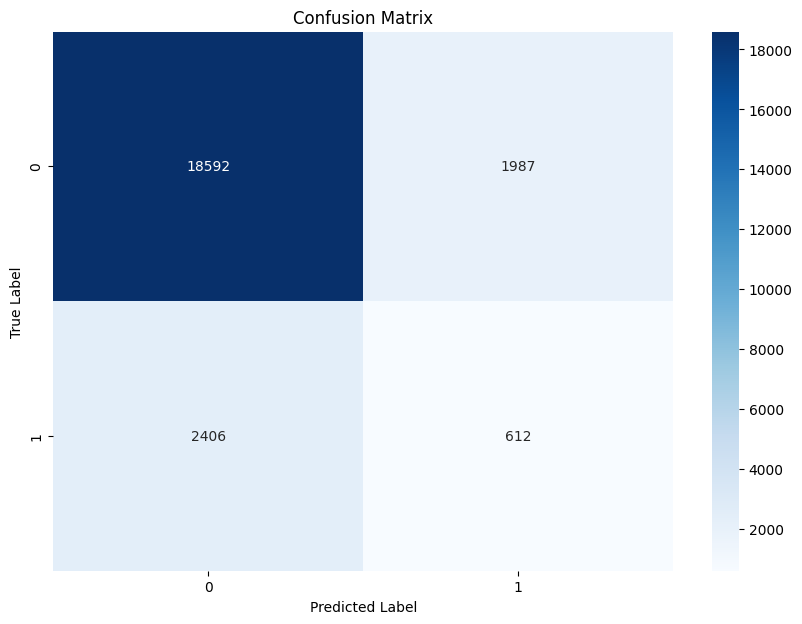

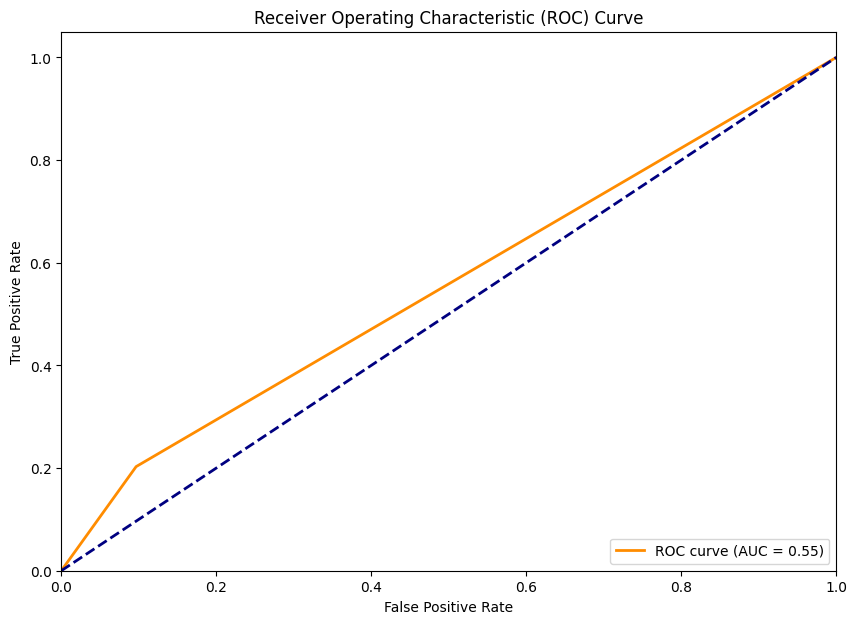

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
from scipy.sparse import csr_matrix, hstack, vstack
import matplotlib.pyplot as plt
import seaborn as sns

# ... (keep your data loading and preprocessing code the same)

# 3. Train the model
clf = IsolationForest(contamination=0.1, random_state=42)  # assume 10% anomalies
clf.fit(X_train)

# 4. Combine test datasets and evaluate
X_test_combined = vstack([X_test_normal, X_test_abnormal])
y_test_combined = np.concatenate([np.zeros(test_normal.shape[0]), np.ones(test_abnormal.shape[0])])

def evaluate_model(model, X, y, dataset_name):
    # IsolationForest returns 1 for inliers and -1 for outliers
    y_pred = model.predict(X)
    # Convert to 0 for normal, 1 for anomaly
    y_pred = (y_pred == -1).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='weighted')
    
    print(f"Results for {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    return cm, y_pred  # Return the confusion matrix and predictions

# Evaluate and get the confusion matrix and predictions
cm, y_pred = evaluate_model(clf, X_test_combined, y_test_combined, "Combined Test Set (Normal + Abnormal)")

# Calculate and print additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # same as recall for the positive class
print(f"\nSpecificity: {specificity:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Optional: ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test_combined, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

___
# <font color = darkkhaki> IsolationForest - Next (Claude)
> after taking into account the categorical logic

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data
# train_data = pd.read_parquet('/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/train_preprocessed.parquet')
test_normal = pd.read_parquet('/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/test_normal_preprocessed.parquet')
# test_abnormal = pd.read_parquet('/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/test_abnormal_preprocessed.parquet')

def preprocess_data(df):
    # 1. Event counts
    event_counts = df.apply(lambda row: pd.Series(row.value_counts()), axis=1).fillna(0)
    
    # 2. Unique events
    unique_events = df.apply(lambda row: len(np.unique(row[row != 0])), axis=1)
    
    # 3. Most frequent event
    most_frequent_event = df.apply(lambda row: row.value_counts().index[0] if len(row.value_counts()) > 0 else 0, axis=1)
    
    # 4. Number of transitions (changes from one event to another)
    def count_transitions(row):
        arr = row.values  # Convert to numpy array
        return np.sum(arr[:-1] != arr[1:])
    transitions = df.apply(count_transitions, axis=1)
    
    # 5. Entropy of event distribution
    def calculate_entropy(row):
        arr = row.values[row.values != 0]  # Remove zeros and convert to numpy array
        _, counts = np.unique(arr, return_counts=True)
        return entropy(counts) if len(counts) > 0 else 0
    entropy_values = df.apply(calculate_entropy, axis=1)
    
    # Combine features
    features = pd.concat([event_counts, 
                          pd.Series(unique_events, name='unique_events'),
                          pd.Series(most_frequent_event, name='most_frequent_event'),
                          pd.Series(transitions, name='transitions'),
                          pd.Series(entropy_values, name='entropy')], axis=1)
    
    return features

# Preprocess data
# X_train = preprocess_data(train_data)
X_test_normal = preprocess_data(test_normal)
# X_test_abnormal = preprocess_data(test_abnormal)

In [12]:
# Combine test datasets
X_test_combined = pd.concat([X_test_normal, X_test_abnormal])
y_test_combined = np.concatenate([np.zeros(test_normal.shape[0]), np.ones(test_abnormal.shape[0])])

### Save and reload files

In [14]:
import pandas as pd
import os

# After preprocessing
save_folder = '/mnt/efs-w210-capstone/200015/09.Models/20240702_IsolationForest_Claude'

# Ensure the save folder exists
os.makedirs(save_folder, exist_ok=True)

# Save preprocessed data
X_train.to_parquet(os.path.join(save_folder, 'X_train_preprocessed.parquet'))
X_test_normal.to_parquet(os.path.join(save_folder, 'X_test_normal_preprocessed.parquet'))
X_test_abnormal.to_parquet(os.path.join(save_folder, 'X_test_abnormal_preprocessed.parquet'))

# Save labels for test data
# Convert y_test_combined to a DataFrame before saving
pd.DataFrame({'label': y_test_combined}).to_parquet(os.path.join(save_folder, 'y_test_combined.parquet'))

print("Preprocessed data saved successfully.")

Preprocessed data saved successfully.


---

In [21]:
# # Convert column names to strings for all DataFrames
# X_train.columns = X_train.columns.astype(str)
# X_test_normal.columns = X_test_normal.columns.astype(str)
# X_test_abnormal.columns = X_test_abnormal.columns.astype(str)

# # Combine test datasets
# X_test_combined = pd.concat([X_test_normal, X_test_abnormal])
# X_test_combined.columns = X_test_combined.columns.astype(str)

# # Train the model
# clf = IsolationForest(contamination=0.1, random_state=42)
# clf.fit(X_train)

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assume X_train, X_test_normal, X_test_abnormal are your preprocessed datasets

# Get all unique columns
all_columns = pd.Index(X_train.columns.union(X_test_normal.columns).union(X_test_abnormal.columns))

# Reindex all datasets
X_train = X_train.reindex(columns=all_columns, fill_value=0)
X_test_normal = X_test_normal.reindex(columns=all_columns, fill_value=0)
X_test_abnormal = X_test_abnormal.reindex(columns=all_columns, fill_value=0)

# Combine test datasets
X_test_combined = pd.concat([X_test_normal, X_test_abnormal])

# Ensure all column names are strings
X_train.columns = X_train.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Train the model
clf = IsolationForest(contamination=0.1, random_state=42)
clf.fit(X_train)

IsolationForest(contamination=0.1, random_state=42)

### Save the Model and load back

In [23]:
import joblib
import os

save_folder = '/mnt/efs-w210-capstone/200015/09.Models/20240702_IsolationForest_Claude'

# Ensure the directory exists
os.makedirs(save_folder, exist_ok=True)

# Save the trained model
joblib.dump(clf, os.path.join(save_folder, 'isolation_forest_model.joblib'))

# Save the feature names (column names)
joblib.dump(X_train.columns.tolist(), os.path.join(save_folder, 'feature_names.joblib'))

# Save other relevant data if needed
# For example, you might want to save the contamination value used
joblib.dump(0.1, os.path.join(save_folder, 'contamination.joblib'))

print("Model and related data saved successfully.")

Model and related data saved successfully.


In [24]:
import joblib
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

save_folder = '/mnt/efs-w210-capstone/200015/09.Models/20240702_IsolationForest_Claude'

# Load the model
clf = joblib.load(os.path.join(save_folder, 'isolation_forest_model.joblib'))

# Load feature names
feature_names = joblib.load(os.path.join(save_folder, 'feature_names.joblib'))

# Load other data if needed
contamination = joblib.load(os.path.join(save_folder, 'contamination.joblib'))

### Eval

Results for Combined Test Set:
Accuracy: 0.8204
Precision: 0.8417
Recall: 0.8204
F1-score: 0.8298

Confusion Matrix:
[[18019  2560]
 [ 1679  1339]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89     20579
         1.0       0.34      0.44      0.39      3018

    accuracy                           0.82     23597
   macro avg       0.63      0.66      0.64     23597
weighted avg       0.84      0.82      0.83     23597



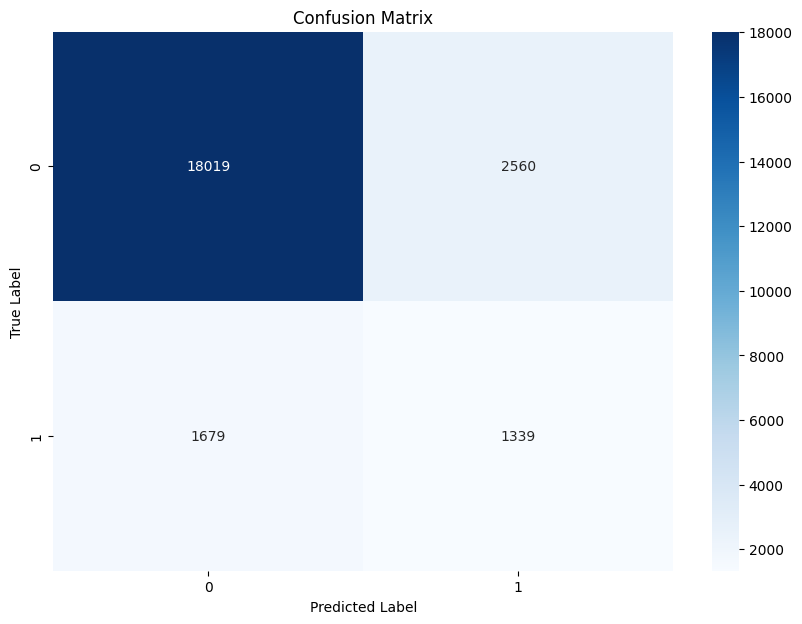

In [25]:
# Evaluate the model
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    y_pred = (y_pred == -1).astype(int)
    
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='weighted')
    
    print(f"Results for {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    return cm, y_pred

cm, y_pred = evaluate_model(clf, X_test_combined, y_test_combined, "Combined Test Set")

# Visualize confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

---

___
# <font color = darkkhaki> M.12: Bert - Basic

### Step 1: Prepare the Data


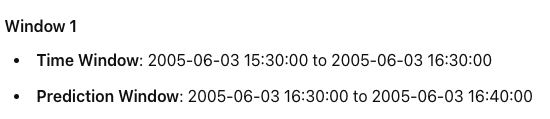

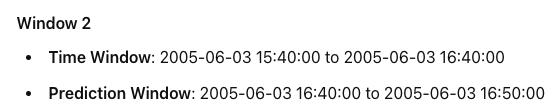

In [8]:
# import pandas as pd

# # Load the data
# file_path = '/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/20240701_BGL_Log_Structuted_v1.00.csv'
# df = pd.read_csv(file_path)

# # Print the minimum and maximum dates
# print(f"Minimum Date: {df['Date'].min()}")
# print(f"Maximum Date: {df['Date'].max()}")

Minimum Date: 2005.06.03
Maximum Date: 2006.01.04


In [10]:
# import pandas as pd
# from datetime import datetime, timedelta
# import numpy as np
# from sklearn.model_selection import train_test_split
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from torch.utils.data import DataLoader, TensorDataset
# import torch

# # Load the data
# file_path = '/mnt/efs-w210-capstone/200015/08.GIT_Repos_Anomaly_Detection/23.Library_Transformers_Logbert_HelenG_BGL/output/bgl/20240701_BGL_Log_Structuted_v1.00.csv'
# df = pd.read_csv(file_path)

# # Extract only the relevant parts of the Time column (removing date if it's duplicated)
# df['Time'] = df['Time'].str.split('-').str[-1]

# # Convert Date and Time columns to datetime
# df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y.%m.%d %H.%M.%S.%f')

# # Sort the data by datetime
# df = df.sort_values(by='datetime')

# # Select relevant columns
# df = df[['datetime', 'Component1', 'Component2', 'Level', 'label_binary']]

# # Function to create rolling window features
# def create_rolling_window_features(df, window_size, prediction_window):
#     X = []
#     y = []
#     for end_time in pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='10T'):
#         start_time = end_time - timedelta(minutes=window_size)
#         prediction_time = end_time + timedelta(minutes=prediction_window)
        
#         window_data = df[(df['datetime'] >= start_time) & (df['datetime'] < end_time)]
#         prediction_data = df[(df['datetime'] >= end_time) & (df['datetime'] < prediction_time)]
        
#         if not window_data.empty and not prediction_data.empty:
#             text = ' '.join(window_data['Component1'].astype(str)) + ' ' + \
#                    ' '.join(window_data['Component2'].astype(str)) + ' ' + \
#                    ' '.join(window_data['Level'].astype(str))
#             label = prediction_data['label_binary'].max()  # Take the max label as the prediction label
            
#             X.append(text)
#             y.append(label)
    
#     return X, y

# # Create rolling window features
# window_size = 60  # 60 minutes
# prediction_window = 10  # 10 minutes
# X, y = create_rolling_window_features(df, window_size, prediction_window)

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Step 3: Create the Model

In [12]:
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# from datasets import Dataset
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# # Load BERT tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# # Tokenize the data
# def tokenize_function(examples):
#     return tokenizer(examples, padding="max_length", truncation=True)

# # Convert data to HuggingFace Datasets
# train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
# test_dataset = Dataset.from_dict({'text': X_test, 'label': y_test})

# train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], padding="max_length", truncation=True), batched=True)
# test_dataset = test_dataset.map(lambda e: tokenizer(e['text'], padding="max_length", truncation=True), batched=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7655 [00:00<?, ? examples/s]

Map:   0%|          | 0/1914 [00:00<?, ? examples/s]

### Step 4: Train the Model

In [13]:
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     accuracy = accuracy_score(labels, preds)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
#     return {
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#     }

In [14]:
# # Define training arguments with adjustments for faster training
# training_args = TrainingArguments(
#     output_dir='./results',
#     evaluation_strategy='steps',
#     eval_steps=500,  # Evaluate every 500 steps
#     logging_dir='./logs',
#     logging_steps=100,  # Log every 100 steps
#     learning_rate=5e-5,  # Reduced learning rate
#     per_device_train_batch_size=16,  # Increased batch size if memory allows
#     per_device_eval_batch_size=16,  # Increased batch size if memory allows
#     num_train_epochs=1,  # Reduced number of epochs
#     weight_decay=0.01,
#     fp16=True,  # Enable mixed precision training
# )

# # Define Trainer with adjusted training arguments
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     compute_metrics=compute_metrics,
# )

# # Train the model
# trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=479, training_loss=0.29039111764545483, metrics={'train_runtime': 138.0713, 'train_samples_per_second': 55.442, 'train_steps_per_second': 3.469, 'total_flos': 2014115128780800.0, 'train_loss': 0.29039111764545483, 'epoch': 1.0})

### Step 5: Save the Model

In [15]:
# # Define the save directory
# save_dir = '/mnt/efs-w210-capstone/200015/09.Models/20240701_Baseline_Bert_Full_OpenAI'

# # Create the directory if it doesn't exist
# import os
# os.makedirs(save_dir, exist_ok=True)

# # Save the model
# model.save_pretrained(save_dir)

# # Save the tokenizer
# tokenizer.save_pretrained(save_dir)

('/mnt/efs-w210-capstone/200015/09.Models/20240701_Baseline_Bert_Full_OpenAI/tokenizer_config.json',
 '/mnt/efs-w210-capstone/200015/09.Models/20240701_Baseline_Bert_Full_OpenAI/special_tokens_map.json',
 '/mnt/efs-w210-capstone/200015/09.Models/20240701_Baseline_Bert_Full_OpenAI/vocab.txt',
 '/mnt/efs-w210-capstone/200015/09.Models/20240701_Baseline_Bert_Full_OpenAI/added_tokens.json')

### Step 7: Load the saved model

In [16]:
# from transformers import BertTokenizer, BertForSequenceClassification

# # Define the save directory
# save_dir = '/mnt/efs-w210-capstone/200015/09.Models/20240701_Baseline_Bert_OpenAI'

# # Load the model
# model = BertForSequenceClassification.from_pretrained(save_dir)

# # Load the tokenizer
# tokenizer = BertTokenizer.from_pretrained(save_dir)

### Step 8: Evaluate the Model

### auto metrics

In [17]:
# # # Evaluate the model
# # results = trainer.evaluate()

# # print(f"Test Loss: {results['eval_loss']}")
# # print(f"Test Accuracy: {results['eval_accuracy']}")

# # Evaluate the model
# results = trainer.evaluate()

# print(f"Test Loss: {results['eval_loss']}")
# print(f"Test Accuracy: {results['eval_accuracy']}")
# print(f"Test Precision: {results['eval_precision']}")
# print(f"Test Recall: {results['eval_recall']}")
# print(f"Test F1 Score: {results['eval_f1']}")

Test Loss: 0.27646970748901367
Test Accuracy: 0.91901776384535
Test Precision: 0.0
Test Recall: 0.0
Test F1 Score: 0.0


### manual metrics

In [18]:
# # Evaluate the model
# predictions = trainer.predict(test_dataset)
# preds = predictions.predictions.argmax(-1)
# labels = predictions.label_ids

In [12]:
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# # Calculate metrics
# accuracy = accuracy_score(labels, preds)
# precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
# cm = confusion_matrix(labels, preds)

# print(f"Test Loss: {predictions.metrics['test_loss']}")
# print(f"Test Accuracy: {accuracy}")
# print(f"Test Precision: {precision}")
# print(f"Test Recall: {recall}")
# print(f"Test F1 Score: {f1}")
# print("Confusion Matrix:")
# print(cm)

Test Loss: 0.12221391499042511
Test Accuracy: 0.9262755913864432
Test Precision: 0.0
Test Recall: 0.0
Test F1 Score: 0.0
Confusion Matrix:
[[8732    0]
 [ 695    0]]


___

#### <font color = tomato>Results Backup
> 
> 
___

___
# <font color = darkkhaki> M

___

#### <font color = tomato>Results Backup
> 
> 
___

___
# <font color = darkkhaki> M

___

#### <font color = tomato>Results Backup
> 
> 
___